<a href="https://colab.research.google.com/github/IgnacioPardo/DavidBlade/blob/main/David_Blade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 **DAVID BLADE**

## 🌍 [Web](https://bit.ly/3H0t986)

Experimento basado en [McCoy, J. P., & Ullman, T. D. (2018). A Minimal Turing Test. Journal of Experimental Social Psychology, 79](https://www.sciencedirect.com/science/article/pii/S0022103117303980?via%3Dihub)



# 🛠 Tools

### Para generar Psytoolkit survey.txt


A partir de un set de 4 categorias, cada una con entre 4 y 6 palabras, se genera la encuesta formateada para ser integrada en psytoolkit.



```python
# Ejemplo
"Palabras" : {
  'Affect' 		: {'Empatia', 'Emocion', 'Sentimientos', 'Simpatia', 'Felicidad'},
    'LDBP' 		: {'Vivo', 'Dolor', 'Sexo', 'Caca'},
    'Lunf' 		: {'Birra', 'Boludo', 'Bondi', 'Che', 'Morfar'},
    'Tech' 		: {'Celular', 'Dron', 'Procesador', 'Robot', 'Smart-TV'}
}
```



Se genera de la siguiente forma.

- Calcula el producto cartesiano de todos los sets de palabras. Esto permite que no compitan palabras de la misma categoria ya que no lo estamos evaluando.

- Se genera un set conteniendo todos los posibles subsets de la forma {palabra_cat1, palabra_cat2, palabra_cat3, palabra_cat4}. A partir de el, se seleccionan todas las combinaciones posibles para agarrar sets de 2 palabras.

- Luego se selecciona una cantidad qB de lotes, cada uno conteniendo una cantidad qI de sets de 2 palabras.

En funcion a este set de qB sets de qI palabras, se genera un archivo survey.txt que funciona de la siguiente forma:

- Comienza con una eleccion al azar de un indice entre 0 y qB, en funcion a el, el survey elijira un lote de preguntas mediante un salto condicional.

- Cada lote cuenta con qI labels, cada una con un slider en el cual los extremos pertenecen a 1 de las 4 categorias de las que se "enfrentan", las cuales se indican en el nombre de la label para ser usados a la hora de procesar los datos.

- Ademas, se generan dos preguntas de control, que a su vez sirven de destino para los saltos condicionales, tanto para el comienzo de un lote como para el final de el.

In [168]:
import itertools
import numpy as np
import random
import os

In [169]:
# Palabras por categoria y descripcion

cat_descrip = {
		"Descripcion"	: {
					'Affect' 	: "Afectos",
					'LDBP' 		: "Vida y muerte, funciones corporales y blasfemias",
					'Lunf' 		: "Lunfardo",
					'Tech' 		: "Tecnología"
				},
		"Palabras"		: {
				'Affect' 		: {'Empatia', 'Emocion', 'Sentimientos', 'Simpatia', 'Felicidad'},
					'LDBP' 		: {'Vivo', 'Dolor', 'Sexo', 'Caca'},
					'Lunf' 		: {'Birra', 'Boludo', 'Bondi', 'Che', 'Morfar'},
					'Tech' 		: {'Celular', 'Dron', 'Procesador', 'Robot', 'Smart-TV'}
				}
}

#Palabras por categoria
words = cat_descrip["Palabras"]

# ID numerico por categoria
word_id = {k: i for i, k in enumerate(words.keys())}
		
# Categoria por palabra
relations = {word:cat for cat, cat_words in words.items() for word in cat_words}

In [170]:
# Calcula el producto cartesiano de todos los sets de palabras. Esto permite que no compitan palabras de la misma categoria ya que no lo estamos evaluando.
# ((x,y) for x in A for y in B)
prod = list(itertools.product(*words.values()))

# Combinaciones del tipo (catX, catY) entre (op_cat1, op_cat2, op_cat3, op_cat4)
arr = np.array([list(itertools.permutations(list(group), 2)) for group in prod])

# Reshape a array de (catX, catY)
arr = arr.reshape((arr.shape[0] * arr.shape[1], 2))
combinations = arr.tolist()

# Permutaciones
# Las combinaciones se convierten a string de la forma "cat1_cat2" para ser usadas como key en el diccionario unit. Los valores son set {cat1, cat2}
unit = {"_".join(sorted([relations[w] for w in pair])+sorted(pair)): set(pair) for pair in combinations}

# Para aprovechar distinto los valores obtenidos.
# perm = {"_".join(sorted(pair)): {ws[1]: ws[0] for ws in [(w, relations[w]) for w in pair]} for pair in combinations}

In [171]:
# Psytoolkit range slider template
template = "l: Batch_index\nt: range\nq: ¿Que palabra la dijo el robot?\n"
slider = "- {min=-1,max=1,start=0,left=leftVal,right=rightVal,by=0}\n"

In [172]:
# Batch generator, qB: Batch quantity
qB = 10
qI = 10
batches = [random.sample([set(s) for s in unit.values()], qI) for _ in range(qB)]

In [173]:
# Psytoolkit survey generator

os.system("rm -rf survey.txt")
with open('survey.txt', 'a') as survey_file:
  survey_file.write('l: chooserandom\n')
  survey_file.write('t: set\n')
  survey_file.write('- random 1 {q}\n'.format(q=qB))
  
  survey_file.write('\n')
  
  survey_file.write('l:\n')
  survey_file.write('t: jump\n')

  for i in range(qB):
    survey_file.write('- if $chooserandom == {iB1} then goto Batch_{iB2}\n'.format(iB1=i+1, iB2=i+1))

  survey_file.write('\n')
  
  for i, batch in enumerate(batches):
    survey_file.write('\n')
    survey_file.write('l: Batch_{iB}\n'.format(iB=i+1))
    survey_file.write('t: radio\n')
    survey_file.write('q: ¿Quien es David Blade?\n')
    survey_file.write('- 🤖 Un Robot\n')
    survey_file.write('- 👥 Tu amigo\n')
    survey_file.write('\n')

    for j, pair in enumerate(batch):
      left, right = list(pair)
      label = "_" + relations[left] + '_' + relations[right] + '_' + str(i+1) + "_" + str(j+1)
      survey_file.write(template.replace("index", label))
      survey_file.write(slider.replace("leftVal", left).replace("rightVal", right))
      survey_file.write('\n')
    survey_file.write("l:\n")
    survey_file.write("t: jump\n")
    survey_file.write("- goto end\n")
    survey_file.write('\n')
  
  survey_file.write('\n')
  survey_file.write('l: end\n')
  survey_file.write('t: radio\n')
  survey_file.write('q: ¿Quien es David Blade?\n')
  survey_file.write('- 🤖 Un Robot\n')
  survey_file.write('- 👥 Tu amigo\n')
  survey_file.write('\n')

# 🧮 Survey Data
Postprocessing de los datos obtenidos en Psytoolkit

In [174]:
import pandas as pd
from IPython.display import display, Markdown

In [175]:
#Psytoolkit survey data
df = pd.read_csv('data.csv') 
df

,participant,chooserandom:1,Batch_1:1,Batch__Lunf_Affect_1_1:1,Batch__LDBP_Tech_1_2:1,Batch__Lunf_Affect_1_3:1,Batch__LDBP_Affect_1_4:1,Batch__LDBP_Affect_1_5:1,Batch__Affect_Lunf_1_6:1,Batch__Lunf_LDBP_1_7:1,Batch__Affect_LDBP_1_8:1,Batch__Lunf_Affect_1_9:1,Batch__LDBP_Tech_1_10:1,Batch_2:1,Batch__Tech_Affect_2_1:1,Batch__Tech_Affect_2_2:1,Batch__Tech_Lunf_2_3:1,Batch__LDBP_Affect_2_4:1,Batch__Lunf_Affect_2_5:1,Batch__Lunf_Affect_2_6:1,Batch__Lunf_Affect_2_7:1,Batch__Lunf_Affect_2_8:1,Batch__Tech_Affect_2_9:1,Batch__Lunf_LDBP_2_10:1,Batch_3:1,Batch__LDBP_Affect_3_1:1,Batch__Affect_LDBP_3_2:1,Batch__LDBP_Affect_3_3:1,Batch__Lunf_Affect_3_4:1,Batch__LDBP_Lunf_3_5:1,Batch__Affect_LDBP_3_6:1,Batch__Lunf_Tech_3_7:1,Batch__LDBP_Lunf_3_8:1,Batch__Tech_LDBP_3_9:1,Batch__Lunf_Affect_3_10:1,Batch_4:1,Batch__Lunf_Affect_4_1:1,Batch__Tech_Affect_4_2:1,Batch__Affect_Lunf_4_3:1,Batch__Tech_Lunf_4_4:1,...,Batch__Tech_Affect_7_9:1,Batch__Tech_Affect_7_10:1,Batch_8:1,Batch__Affect_Tech_8_1:1,Batch__LDBP_Tech_8_2:1,Batch__Tech_LDBP_8_3:1,Batch__Tech_Lunf_8_4:1,Batch__LDBP_Lunf_8_5:1,Batch__LDBP_Affect_8_6:1,Batch__Lunf_Affect_8_7:1,Batch__Affect_LDBP_8_8:1,Batch__LDBP_Lunf_8_9:1,Batch__Affect_Lunf_8_10:1,Batch_9:1,Batch__Affect_Lunf_9_1:1,Batch__LDBP_Lunf_9_2:1,Batch__Affect_Lunf_9_3:1,Batch__Affect_Tech_9_4:1,Batch__Tech_LDBP_9_5:1,Batch__Affect_Tech_9_6:1,Batch__Affect_LDBP_9_7:1,Batch__Tech_LDBP_9_8:1,Batch__Tech_Affect_9_9:1,Batch__LDBP_Affect_9_10:1,Batch_10:1,Batch__Lunf_Affect_10_1:1,Batch__LDBP_Affect_10_2:1,Batch__Lunf_LDBP_10_3:1,Batch__Tech_Lunf_10_4:1,Batch__Lunf_Affect_10_5:1,Batch__Tech_LDBP_10_6:1,Batch__Affect_LDBP_10_7:1,Batch__Tech_Affect_10_8:1,Batch__Tech_Lunf_10_9:1,Batch__Lunf_LDBP_10_10:1,end:1,TIME_start,TIME_end,TIME_total,id
0,s.85b8f059-b7e1-4a64-ac1f-42ba4c000be7.txt,1,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-02-15-01,NaN,NaN,NaN
1,s.8aa03b08-efd8-47fc-891e-4bf98b15291b.txt,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-02-12-50,NaN,NaN,NaN
2,s.f7af0f5f-9268-4a36-b8b5-06273fbf6fd6.txt,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-02-12-56,2021-11-02-12-56,0.0,Kq5NzCcATf
3,s.231773c2-ebc9-4c21-945c-e942965032bb.txt,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-02-13-26,NaN,NaN,NaN
4,s.a6621921-16c7-4c72-8271-e87288fda805.txt,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-02-14-20,NaN,NaN,NaN
5,s.ee6b7426-3e7c-435b-8a56-bd42fb51dd29.txt,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# 🧠 Results

In [176]:
# Survey control question conditions results

control_keys = ["Batch_{_i}:1".format(_i=i+1) for i in range(qB)] + ["end:1"]
full = ((df[control_keys]-2) * -1).replace(to_replace=-0.0, value=0).fillna(0)
control = full[control_keys[0]]

for i in range(10):
  control = control + full[control_keys[i+1]]

control = control.replace(to_replace=1, value=0)
control = control.replace(to_replace=2, value=1)

In [177]:
# Llamamos partido al evento de que una categoria haya sido marcada como "robot" contra otra.
# Llamamos torneo a todos los posibles partidos jugados entre 2 categorias.
# Cada set de Matches es un set del estilo {cat1, cat2} para todas las combinaciones cat1-cat2 entre el total de categorias.

matches = {frozenset(sorted(list(t))) for t in list(itertools.permutations(words.keys(), 2))}

# Tournament es un diccionario de la forma key partido, y su valor es un diccionario conteniendo equipo -> partidos ganados contra el otro equipo.
# Ejemplo {'Affect_LDBP': {'Affect': 10, 'LDBP': 5}

tournament = {sorted(list(match))[0]+"_"+sorted(list(match))[1] : {list(match)[0] : 0, list(match)[1] : 0 } for match in matches}

In [178]:
# Contabiliza los "partidos" de los datos obtenidos de psytoolkit
for k in df:
  if "Batch__" in k:
    # El prefijo "Batch__" en una label implica que la columna es un enfrentamiento, a diferencia de informacion extra del experimento (Participante/duracion/indice)
    # Del tipo Batch__cat1_cat2
    df[k] = df[k] * control
    players = k.split("Batch__")[1].split("_")[:2]
    
    # Obtiene el tipo de partido
    match = "_".join(sorted(players))
    left = players[0]
    right = players[1]

    # Determina el ganador del partido en funcion de la respuesta y le suma en el torneo.
    for v in df[k]:
      if v == -1:
        tournament[match][left] += 1
      elif v == 1:
        tournament[match][right] += 1

In [179]:
tournament = pd.DataFrame(tournament)
tournament = tournament.fillna(0).astype(int)

In [180]:
# Direccion de los nodos
graph_relations = []

# Cantidad de veces que una categoria gano mas partidos contra otra categoria

won = {word_id[word]: 0 for word in words}

for k in tournament:
  if k != "sum" and k != "pos":
    cat1, cat2 = k.split("_")
    a, b = tournament[k][cat1], tournament[k][cat2]
    
    # a: cantidad de veces que cat1 le gano a cat2
    # b: cantidad de veces que cat2 le gano a cat1

    # Si cat1 le gano mas veces a cat2 que cat2 a cat1, la direccion en el grafo va de cat1 -> cat2
    if a > b:
      won[word_id[cat1]] += 1
      graph_relations.append((word_id[cat1], word_id[cat2]))
    elif a < b:
      # La direccion en el grafo va de cat2 -> cat1
      graph_relations.append((word_id[cat2], word_id[cat1]))
      won[word_id[cat2]] += 1
    else:
      # La relacion entre los nodos de cat1 y cat2 es bidireccional
      graph_relations.append((word_id[cat2], word_id[cat1]))
      graph_relations.append((word_id[cat1], word_id[cat2]))


In [181]:
import networkx as nx
import matplotlib.pyplot as plt

# Results

### From most to least robotic

,Affect_LDBP,LDBP_Lunf,Affect_Tech,Lunf_Tech,Affect_Lunf,LDBP_Tech
Tech,0,0,3,9,0,8
Affect,12,0,2,0,17,0
LDBP,7,7,0,0,0,2
Lunf,0,2,0,0,1,0


<br><br>

### Grafo

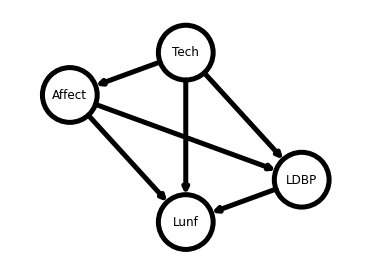

<br><br>

### Keys

,Descripcion,Palabras
Affect,Afectos,"{Simpatia, Empatia, Emocion, Felicidad, Sentim..."
LDBP,"Vida y muerte, funciones corporales y blasfemias","{Vivo, Caca, Sexo, Dolor}"
Lunf,Lunfardo,"{Birra, Boludo, Morfar, Che, Bondi}"
Tech,Tecnología,"{Dron, Procesador, Robot, Smart-TV, Celular}"


In [182]:
# Categoria by ID
labels = {i: k for k, i in word_id.items()}

options = {
    "font_size": 12,
    "node_size": 3000,
    "node_color": [(0,0,0,0) for _ in range(len(labels))],
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
    "labels": labels,
}

# Para ordenar el torneo en funcion de sus ordenes, basado por los valores del diccionario won
ordered_tournament = tournament
ordered_tournament["pos"] = pd.Series([0, 0, 0, 0])

G = nx.DiGraph(graph_relations)

# Posicion para los 4 nodos del grafo
pos = [(0.5, 1), (0, 0.5), (1, 0.5), (0.5, 0)]

# Orden de los labels (medido por partidos ganados)
order = sorted(won.items(), key=lambda item: item[1], reverse=True)

# coordenadas por categoria
l_pos = {}

# Itera por las categorias
for i, n in enumerate(order):
  
  # Setea la posicion de la categoria en el DataFrame del torneo
  ordered_tournament.at[labels[n[0]], 'pos'] = len(order) - (i + 1)

  # Setea las coordenadas del nodo para la categoria
  l_pos[n[0]] = pos[i]
  if i == 2:
    l_pos[order[i-1][0]] = (pos[i-1][0], 0.75)
    l_pos[n[0]] = (pos[i][0], 0.25)


nx.draw_networkx(G, l_pos, **options)

ax = plt.gca()
ax.margins(0.20)
plt.axis("off")

display(Markdown("# Results"))
display(Markdown("### From most to least robotic"))
display(ordered_tournament.sort_values(by=['pos'], ascending=False).drop('pos', axis=1))

display(Markdown("<br><br>"))

display(Markdown("### Grafo"))
# plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.show()

display(Markdown("<br><br>"))

display(Markdown("### Keys"))
display(pd.DataFrame(cat_descrip))

# 🤖 **DAVID BLADE**

### 🧠 Integrantes: Luca Mazzarello - Camila Migdal Mamrud - Azul Noguera - Ignacio Pardo

### 📅 Fecha: Noviembre 2021

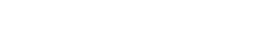